In [3]:
# !pip install dagshub mlflow

import dagshub
import mlflow
import mlflow.keras
import os

import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 137.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [7]:
DAGSHUB_USERNAME = "Arej02"
DAGSHUB_REPO_NAME = "CNN"

# Setup DagsHub connection
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME)

# Set MLflow tracking to DagsHub
mlflow.set_tracking_uri(f"https://dagshub.com/Arej02/CNN.mlflow")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=5dccf8b3-fd7f-451d-aeaf-a00d8ca32697&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=29ef14826d0ff27b949461bdc652f1a5c8d2d3308a27cec839c9987eacc5d42e




Accessing as Arej02

Initialized MLflow to track repo "Arej02/CNN"

Repository Arej02/CNN initialized!

### Hyperparameter Tuning in a ANN:

In [8]:
def train_with_mlflow(config):
    run_name = f"HP_{config['hidden_nodes']}n_{config['batch_size']}bs_{config['img_size']}img"

    with mlflow.start_run(run_name=run_name):
        # Log hyperparameters
        mlflow.log_params(config)

        # Your existing training code (without MLflow callbacks)
        CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
        IMG_CHANNELS = 3

        def read_and_decode(filename, resize_dims):
            img_bytes = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, resize_dims)
            return img

        def parse_csvline(csv_line):
            record_default = ["", ""]
            filename, label_string = tf.io.decode_csv(csv_line, record_default)
            img = read_and_decode(filename, [config['img_size'], config['img_size']])
            label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
            return img, label

        train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(config['batch_size'])
            .prefetch(tf.data.AUTOTUNE)
        )

        eval_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(config['batch_size'])
            .prefetch(tf.data.AUTOTUNE)
        )

        model = keras.Sequential([
            keras.layers.Flatten(input_shape=(config['img_size'], config['img_size'], IMG_CHANNELS)),
            keras.layers.Dense(config['hidden_nodes'], activation="relu"),
            keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
        ])

        model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )

        # Train without MLflow callbacks
        history = model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=config['epochs'],
            verbose=1
        )

        # Manually log the important metrics
        final_val_acc = history.history['val_accuracy'][-1]
        mlflow.log_metric("final_val_accuracy", final_val_acc)
        mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])

        print(f"Run completed: {run_name}")
        print(f"Validation Accuracy: {final_val_acc:.4f}")

        return final_val_acc

In [9]:
# Define different hyperparameter combinations to try
hyperparameter_configs = [
    # Small network, small batch
    {'hidden_nodes': 128, 'batch_size': 16, 'img_size': 128, 'epochs': 5},

    # Medium network, medium batch
    {'hidden_nodes': 256, 'batch_size': 32, 'img_size': 128, 'epochs': 5},

    # Large network, large batch
    {'hidden_nodes': 512, 'batch_size': 64, 'img_size': 224, 'epochs': 5},

    # Small network, large batch
    {'hidden_nodes': 128, 'batch_size': 64, 'img_size': 224, 'epochs': 5},

    # Large network, small batch
    {'hidden_nodes': 512, 'batch_size': 16, 'img_size': 128, 'epochs': 5},

    # Try different image sizes
    {'hidden_nodes': 256, 'batch_size': 32, 'img_size': 64, 'epochs': 5},
    {'hidden_nodes': 256, 'batch_size': 32, 'img_size': 224, 'epochs': 5},
]

print(f"Testing {len(hyperparameter_configs)} different configurations")

Testing 7 different configurations


In [11]:
# Track the best configuration
best_accuracy = 0
best_config = None
results = []

# Run all configurations with the FIXED function
for i, config in enumerate(hyperparameter_configs):
    print(f"\n{'='*50}")
    print(f"Testing Configuration {i+1}/{len(hyperparameter_configs)}")
    print(f"Config: {config}")

    try:
        val_accuracy = train_with_mlflow(config)  # With MLflow callback but no model logging
        # val_accuracy = train_with_mlflow_simple(config)  # Simple manual logging

        # Store results
        results.append({
            'config': config,
            'val_accuracy': val_accuracy
        })

        # Update best configuration
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_config = config
            print(f"NEW BEST! Accuracy: {val_accuracy:.4f}")
        else:
            print(f"Accuracy: {val_accuracy:.4f}")

    except Exception as e:
        print(f"Failed with config {config}: {e}")
        continue


Testing Configuration 1/7
Config: {'hidden_nodes': 128, 'batch_size': 16, 'img_size': 128, 'epochs': 5}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
    207/Unknown 179s 851ms/step - accuracy: 0.3144 - loss: 6.6635

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 199s 949ms/step - accuracy: 0.3146 - loss: 6.6473 - val_accuracy: 0.2946 - val_loss: 2.8131
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 132s 638ms/step - accuracy: 0.4248 - loss: 1.6502 - val_accuracy: 0.3351 - val_loss: 1.8512
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 107s 516ms/step - accuracy: 0.4708 - loss: 1.3816 - val_accuracy: 0.3243 - val_loss: 2.1902
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 95s 461ms/step - accuracy: 0.4700 - loss: 1.4092 - val_accuracy: 0.3811 - val_loss: 1.4496
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 95s 457ms/step - accuracy: 0.4281 - loss: 1.3513 - val_accuracy: 0.3757 - val_loss: 1.4494
Run completed: HP_128n_16bs_128img
Validation Accuracy: 0.3757
🏃 View run HP_128n_16bs_128img at: https://dagshub.com/Arej02/CNN.mlflow/#/experiments/0/runs/d6f14a22278d4356bc61838c88852709
🧪 View experiment at: https://dagshub.com/Arej02/CNN.mlflow/#/experiments/0
NEW BEST! Accuracy: 0.3757

Testing Configuration 2/7
Config: {'hidden_nodes': 256, 'batch_

In [12]:
print("\nALL RESULTS SUMMARY:")
print("=" * 60)
for i, result in enumerate(results):
    config = result['config']
    accuracy = result['val_accuracy']
    print(f"Run {i+1}: Acc={accuracy:.4f} | "
          f"Nodes={config['hidden_nodes']} | "
          f"Batch={config['batch_size']} | "
          f"ImgSize={config['img_size']}")

# Sort by best accuracy
results_sorted = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

print(f"\nTOP 3 CONFIGURATIONS:")
for i, result in enumerate(results_sorted[:3]):
    config = result['config']
    accuracy = result['val_accuracy']
    print(f"{i+1}. Acc={accuracy:.4f} | "
          f"Nodes={config['hidden_nodes']} | "
          f"Batch={config['batch_size']} | "
          f"ImgSize={config['img_size']}")


ALL RESULTS SUMMARY:
Run 1: Acc=0.3757 | Nodes=128 | Batch=16 | ImgSize=128
Run 2: Acc=0.4622 | Nodes=256 | Batch=32 | ImgSize=128
Run 3: Acc=0.4405 | Nodes=512 | Batch=64 | ImgSize=224
Run 4: Acc=0.4270 | Nodes=128 | Batch=64 | ImgSize=224
Run 5: Acc=0.4108 | Nodes=512 | Batch=16 | ImgSize=128
Run 6: Acc=0.4568 | Nodes=256 | Batch=32 | ImgSize=64
Run 7: Acc=0.3081 | Nodes=256 | Batch=32 | ImgSize=224

TOP 3 CONFIGURATIONS:
1. Acc=0.4622 | Nodes=256 | Batch=32 | ImgSize=128
2. Acc=0.4568 | Nodes=256 | Batch=32 | ImgSize=64
3. Acc=0.4405 | Nodes=512 | Batch=64 | ImgSize=224


## Regularization:

In [1]:
def train_with_mlflow(config):
    run_name = f"HP_{config['hidden_nodes']}n_{config['batch_size']}bs_{config['img_size']}img"

    with mlflow.start_run(run_name=run_name):
        # Log hyperparameters
        mlflow.log_params(config)

        # Your existing training code (without MLflow callbacks)
        CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
        IMG_CHANNELS = 3

        def read_and_decode(filename, resize_dims):
            img_bytes = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, resize_dims)
            return img

        def parse_csvline(csv_line):
            record_default = ["", ""]
            filename, label_string = tf.io.decode_csv(csv_line, record_default)
            img = read_and_decode(filename, 128,128)
            label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
            return img, label

        train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
        )

        eval_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
        )

        regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

        model = keras.Sequential([
            Flatten(input_shape=(128, 128, IMG_CHANNELS)),
            Dense(256, kernel_regularizer=regularizer),  # Only place we make a change in hidden layer
            BatchNormalization(),  # Just before we send it to activation function
            Activation("relu"),
            Dropout(0.5),
            Dense(len(CLASS_NAMES), activation="softmax", kernel_regularizer=regularizer)
        ])

        model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )

        # Train without MLflow callbacks
        history = model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=5,
            verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
                ]
        )

        # Manually log the important metrics
        final_val_acc = history.history['val_accuracy'][-1]
        mlflow.log_metric("final_val_accuracy", final_val_acc)
        mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])

        print(f"Run completed: {run_name}")
        print(f"Validation Accuracy: {final_val_acc:.4f}")

        return final_val_acc

Starting Model Training with Regularization...
Configuration: {'hidden_nodes': 256, 'batch_size': 32, 'img_size': 128, 'epochs': 5}


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training
Epoch 1/5
    104/Unknown 106s 976ms/step - accuracy: 0.3461 - loss: 2.5709

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


104/104 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.3464 - loss: 2.5694 - val_accuracy: 0.4486 - val_loss: 2.1643
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4750 - loss: 1.9690 - val_accuracy: 0.3541 - val_loss: 2.2817
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 98s 942ms/step - accuracy: 0.4972 - loss: 1.7711 - val_accuracy: 0.2811 - val_loss: 2.5768
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 95s 907ms/step - accuracy: 0.5183 - loss: 1.6510 - val_accuracy: 0.4459 - val_loss: 1.8717
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 93s 896ms/step - accuracy: 0.5294 - loss: 1.6105 - val_accuracy: 0.2973 - val_loss: 2.2319


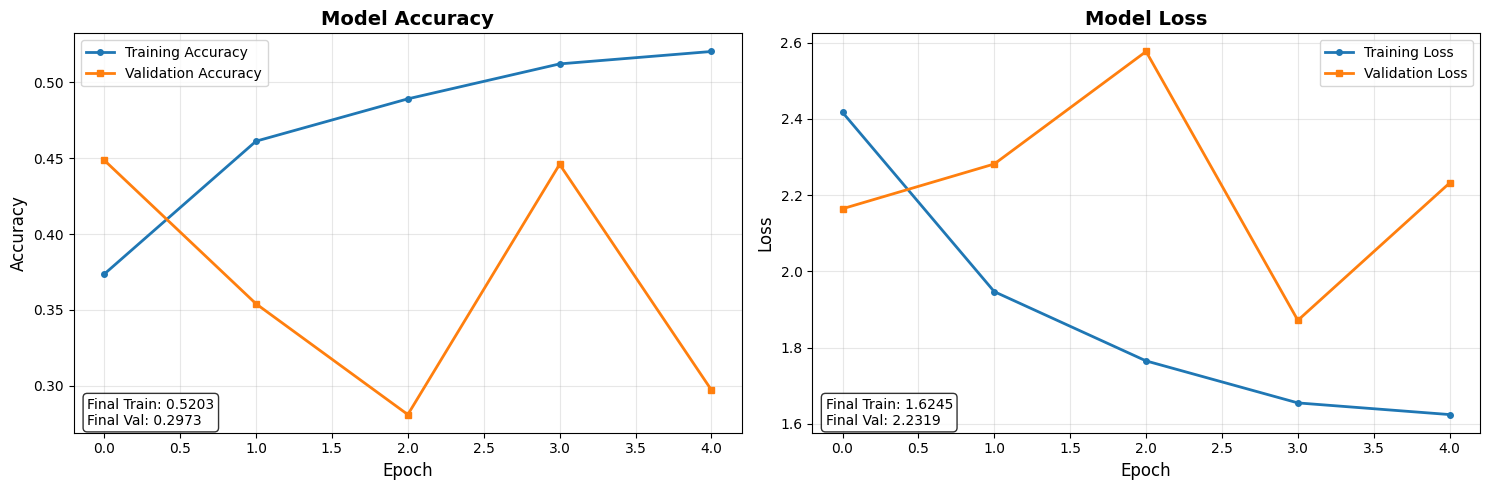


TRAINING SUMMARY:
Final Training Accuracy: 0.5203
Final Validation Accuracy: 0.2973
Final Training Loss: 1.6245
Final Validation Loss: 2.2319
Run completed: HP_256n_32bs_128img
Validation Accuracy: 0.2973

Training Completed!
Final Validation Accuracy: 0.2973


In [4]:
def train_with_mlflow(config):
    run_name = f"HP_{config['hidden_nodes']}n_{config['batch_size']}bs_{config['img_size']}img"

    with mlflow.start_run(run_name=run_name):
        # Log hyperparameters
        mlflow.log_params(config)

        # Your existing training code
        CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
        IMG_CHANNELS = 3

        def read_and_decode(filename, resize_dims):
            img_bytes = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, resize_dims)
            return img

        def parse_csvline(csv_line):
            record_default = ["", ""]
            filename, label_string = tf.io.decode_csv(csv_line, record_default)
            img = read_and_decode(filename, [128, 128])  # Fixed: pass as list
            label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
            return img, label

        train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
        )

        eval_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
        )

        regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

        model = keras.Sequential([
            Flatten(input_shape=(128, 128, IMG_CHANNELS)),
            Dense(256, kernel_regularizer=regularizer),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.5),
            Dense(len(CLASS_NAMES), activation="softmax", kernel_regularizer=regularizer)
        ])

        model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )

        # Train model
        print("Starting training")
        history = model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=5,
            verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            ]
        )

        # Create plots
        create_training_plots(history)

        # Log metrics
        final_val_acc = history.history['val_accuracy'][-1]
        mlflow.log_metric("final_val_accuracy", final_val_acc)
        mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])

        print(f"Run completed: {run_name}")
        print(f"Validation Accuracy: {final_val_acc:.4f}")

        return history, final_val_acc

def create_training_plots(history):
    """Create beautiful training plots"""
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add final accuracy values to the plot
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    ax1.text(0.02, 0.02, f'Final Train: {final_train_acc:.4f}\nFinal Val: {final_val_acc:.4f}',
             transform=ax1.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Plot 2: Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add final loss values to the plot
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    ax2.text(0.02, 0.02, f'Final Train: {final_train_loss:.4f}\nFinal Val: {final_val_loss:.4f}',
             transform=ax2.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nTRAINING SUMMARY:")
    print("="*40)
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

# Run the training
if __name__ == "__main__":
    # Define your config (you can adjust these values)
    config = {
        'hidden_nodes': 256,
        'batch_size': 32,
        'img_size': 128,
        'epochs': 5
    }

    print("Starting Model Training with Regularization...")
    print(f"Configuration: {config}")
    print("="*50)

    # Run training and get plots
    history, final_accuracy = train_with_mlflow(config)

    print(f"\nTraining Completed!")
    print(f"Final Validation Accuracy: {final_accuracy:.4f}")